In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
import os

Using TensorFlow backend.
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [3]:
p = Pipeline(working_folder=f'{main_path}/Snapshots/1')
p.add_node(LoaderNode, None, 'train',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_train.csv'
           })
p.add_node(LoaderNode, None, 'test',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_test.csv'
           })
p.run()


---------------------------
0: LoaderNode [2019-12-16 23:19:37]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_train.csv'}
---------------------------
1: LoaderNode [2019-12-16 23:19:38]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_test.csv'}


In [4]:
def mix_train_test(dfs):
    df_train, df_test = dfs
    df_train['orderid'] = df_train['orderid'] + 1000000
    df_train = df_train.set_index('orderid')
    df_test = df_test.set_index('orderid')
    data = pd.concat([df_train, df_test], axis=0, sort=False )
    data.fillna(-1,inplace=True)
    return data

p.add_node(FunctionNode, ('train','test'),'data',
           params={
               'function': mix_train_test
           })
p.run()

---------------------------
2: FunctionNode [2019-12-16 23:19:39]
params:
 {'function': <function mix_train_test at 0x000001E93BAA9A60>}


In [5]:
p.add_node(EraserNode, params={
    'remove_keys': ['train', 'test']
})
p.run()

---------------------------
3: EraserNode [2019-12-16 23:19:40]
params:
 {'remove_keys': ['train', 'test']}


In [6]:
def set_categorical_features(df):
    cat_fields = ['field12', 'field26', 'field27', 'field29']
    for f in cat_fields:
        df[f] = pd.Categorical(df[f])
    return df

p.add_node(FunctionNode, 'data','data',
           params={
               'function': set_categorical_features
           })
p.run()


---------------------------
4: FunctionNode [2019-12-16 23:19:41]
params:
 {'function': <function set_categorical_features at 0x000001E94E5E6D90>}


## Features

In [7]:
p.data['data'].columns

Index(['userid', 'field0', 'field1', 'field2', 'field3', 'field4', 'field5',
       'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field12',
       'field13', 'field14', 'field15', 'field16', 'field17', 'field18',
       'field19', 'field20', 'field21', 'field22', 'field23', 'field24',
       'field25', 'field26', 'field27', 'field28', 'field29',
       'indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1'],
      dtype='object')

In [8]:
num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid']
for gb in groupby_features:
    p.add_node(AddAggregatesTotalNode, 'data','data',
               params={
                   'features': [f'field{q}' for q in num_features],
                   'group_by': gb
               })
p.run()

---------------------------
5: AddAggregatesTotalNode [2019-12-16 23:19:41]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': 'field5'}
---------------------------
6: AddAggregatesTotalNode [2019-12-16 23:19:44]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': 'field7'}
---------------------------
7: AddAggregatesTotalNode [2019-12-16 23:19:49]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': 'field8'}
---------------------------
8: AddAggregatesTotalNode [2019-12-16 23:19:57]
params:
 {'features': ['field0', 'field1',

In [9]:
p.data['data'].columns

Index(['userid', 'field0', 'field1', 'field2', 'field3', 'field4', 'field5',
       'field6', 'field7', 'field8',
       ...
       'field22_to_mean_userid', 'field22_to_std_userid',
       'field23_to_mean_userid', 'field23_to_std_userid',
       'field24_to_mean_userid', 'field24_to_std_userid',
       'field25_to_mean_userid', 'field25_to_std_userid',
       'field28_to_mean_userid', 'field28_to_std_userid'],
      dtype='object', length=330)

In [10]:
ultimate_feature=12
num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
groupby_features = [f'field{q}' for q in [26,27,29]] + ['userid']
for gb in groupby_features:
    p.add_node(AddGroupNumericalAggregatesNode, 'data','data',
               params={
                   'features': [f'field{q}' for q in num_features],
                   'group_by': [f'field{ultimate_feature}',gb],
                   'to_mean': True,
                   'to_std_score': True
               })
p.run()

---------------------------
14: AddGroupNumericalAggregatesNode [2019-12-16 23:21:55]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field12', 'field26'], 'to_mean': True, 'to_std_score': True}
---------------------------
15: AddGroupNumericalAggregatesNode [2019-12-16 23:22:00]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field12', 'field27'], 'to_mean': True, 'to_std_score': True}
---------------------------
16: AddGroupNumericalAggregatesNode [2019-12-16 23:22:05]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'gro

In [11]:
groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid']
cat_features = groupby_features

for gb in groupby_features:
    p.add_node(AddGroupFrequencyEncodingNode, 'data','data',
               params={
                   'features': [c for c in cat_features if c != gb],
                   'group_by': [gb],
                   'count': True,
                   'freq': False
               })
p.run()

---------------------------
18: AddGroupFrequencyEncodingNode [2019-12-16 23:22:35]
params:
 {'features': ['field7', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid'], 'group_by': ['field5'], 'count': True, 'freq': False}
0 field5
---------------------------
19: AddGroupFrequencyEncodingNode [2019-12-16 23:22:42]
params:
 {'features': ['field5', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid'], 'group_by': ['field7'], 'count': True, 'freq': False}
0 field7
---------------------------
20: AddGroupFrequencyEncodingNode [2019-12-16 23:22:48]
params:
 {'features': ['field5', 'field7', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid'], 'group_by': ['field8'], 'count': True, 'freq': False}
0 field8
---------------------------
21: AddGroupFrequencyEncodingNode [2019-12-16 23:22:53]
params:
 {'features': ['field5', 'field7', 'field8', 'field12', 'field26', 'field27', 'field29', 'userid'], 'group_by': ['field10'], 'count': True, 

## Training


In [12]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1','userid',]

In [13]:
data = p.data['data']
X = data[data['goal1']>=0].drop(['goal1'], axis=1)
y = data[data['goal1']>=0]['goal1']
test=data[data['goal1']<0]
train_features = [f for f in data.columns if f not in exclude_features_from_training]


In [14]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          'objective': 'binary',
          "metric": 'auc',
          "verbosity": -1,
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 500,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Mon Dec 16 23:23:56 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904606	training's auc: 0.904606	valid_1's auc: 0.671887	valid_1's auc: 0.671887
Early stopping, best iteration is:
[50]	training's auc: 0.847829	training's auc: 0.847829	valid_1's auc: 0.676644	valid_1's auc: 0.676644
Fold 2 started at Mon Dec 16 23:24:55 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900505	training's auc: 0.900505	valid_1's auc: 0.712615	valid_1's auc: 0.712615
Early stopping, best iteration is:
[34]	training's auc: 0.810291	training's auc: 0.810291	valid_1's auc: 0.718987	valid_1's auc: 0.718985
Fold 3 started at Mon Dec 16 23:25:42 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900145	training's auc: 0.900145	valid_1's auc: 0.694774	valid_1's auc: 0.694774
Early stopping, best iteration is:
[46]	training's auc: 0.84242	training's auc: 0.84242	valid_

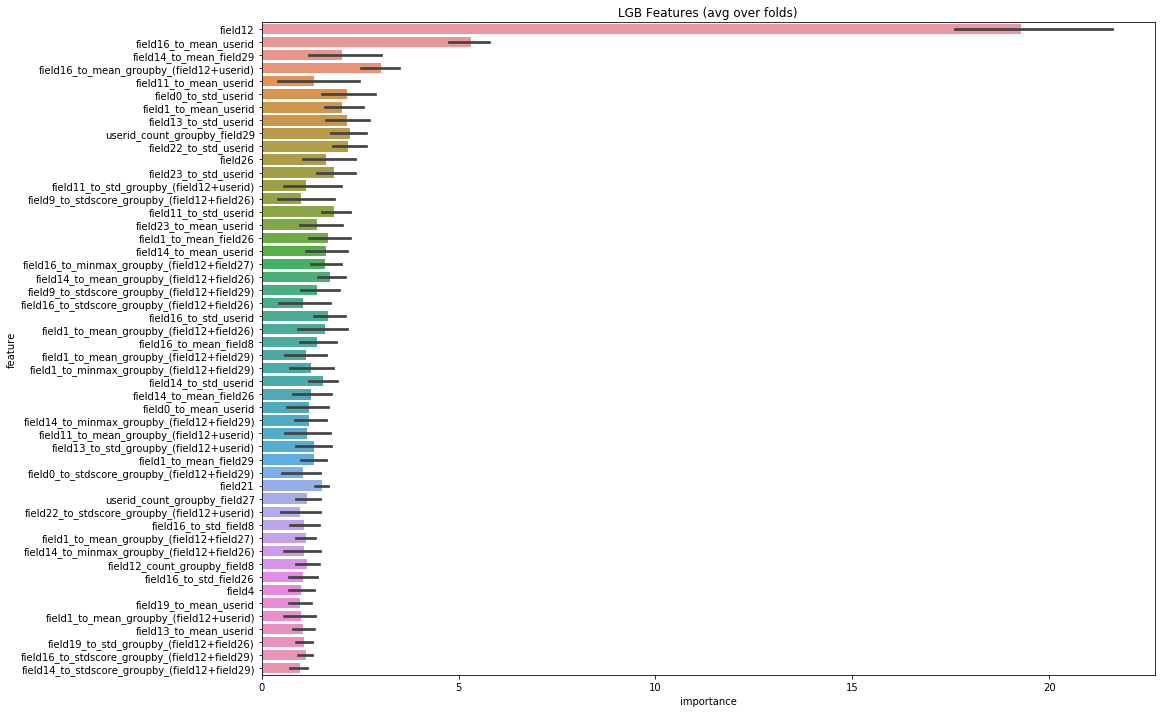

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [16]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'{p.working_folder}/submission-{t}.csv')

## Results

### NO FE. initial

Fold 1 started at Sun Dec 15 19:17:47 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.8352	training's auc: 0.8352	valid_1's auc: 0.660413	valid_1's auc: 0.660413
Early stopping, best iteration is:
[36]	training's auc: 0.769533	training's auc: 0.769533	valid_1's auc: 0.671052	valid_1's auc: 0.671052
Fold 2 started at Sun Dec 15 19:17:58 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.832962	training's auc: 0.832962	valid_1's auc: 0.708005	valid_1's auc: 0.708005
Early stopping, best iteration is:
[27]	training's auc: 0.742707	training's auc: 0.742708	valid_1's auc: 0.71381	valid_1's auc: 0.713811
Fold 3 started at Sun Dec 15 19:18:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833846	training's auc: 0.833846	valid_1's auc: 0.684287	valid_1's auc: 0.684287
Early stopping, best iteration is:
[28]	training's auc: 0.753781	training's auc: 0.753782	valid_1's

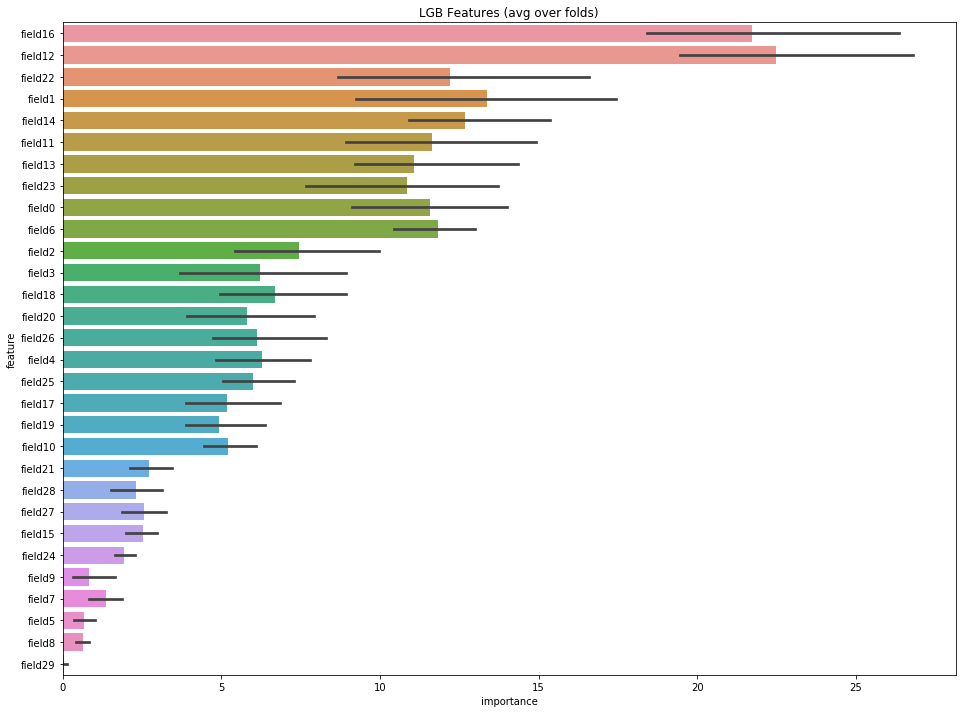

In [22]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### add first aggregate node

Fold 1 started at Sun Dec 15 20:21:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.892444	training's auc: 0.892444	valid_1's auc: 0.672213	valid_1's auc: 0.672213
Early stopping, best iteration is:
[67]	training's auc: 0.857729	training's auc: 0.857729	valid_1's auc: 0.676682	valid_1's auc: 0.676682
Fold 2 started at Sun Dec 15 20:21:38 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890783	training's auc: 0.890783	valid_1's auc: 0.705956	valid_1's auc: 0.705956
Early stopping, best iteration is:
[40]	training's auc: 0.817173	training's auc: 0.817173	valid_1's auc: 0.72028	valid_1's auc: 0.720279
Fold 3 started at Sun Dec 15 20:22:05 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890927	training's auc: 0.890927	valid_1's auc: 0.688385	valid_1's auc: 0.688385
Early stopping, best iteration is:
[33]	training's auc: 0.803194	training's auc: 0.803194	valid

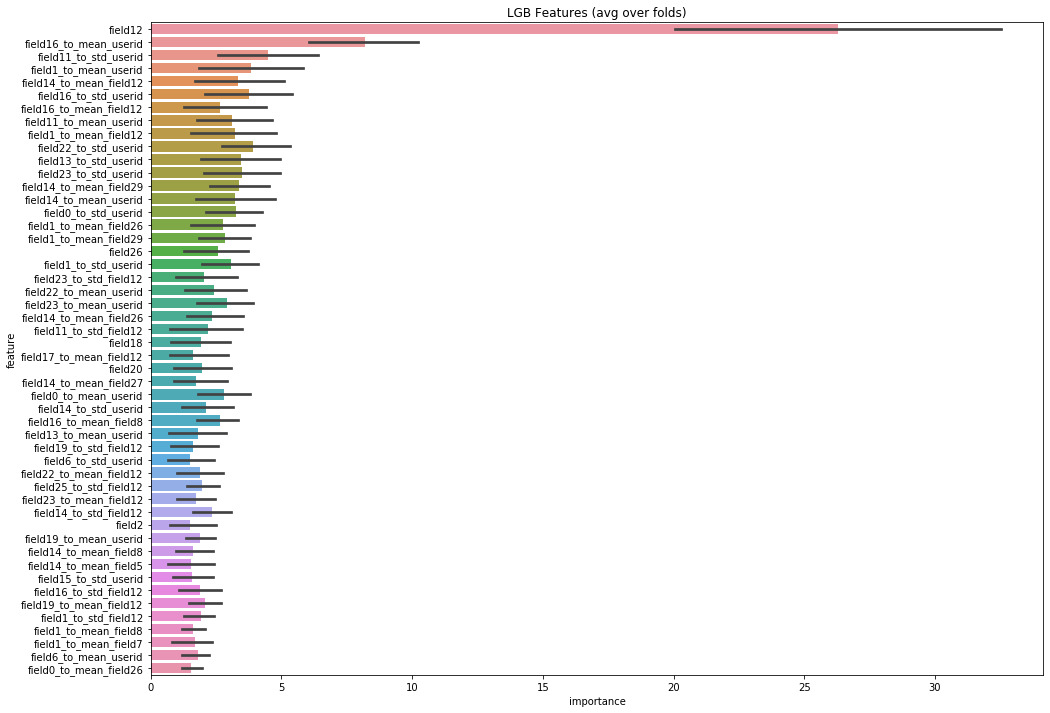

In [13]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)